# 变量解释

Pregnancies: 怀孕次数

Glucose：葡萄糖  正常为3.92-6.16$mmol/L$

BloodPressure;血压（$mm Hg$）正常范围90-140

SkinThickness：皮脂厚度($mm$)超过20即为肥胖

Insulin：2小时血清胰岛素含量（$mu/ml$）正常人为4.03-23.46

BMI： 体重指数($kg/m^2$) BMI大于28即为肥胖

DiabetesPedigreeFunction： 遗传指数

Age; 年龄(岁）

Outcome: 标签 1：患病 0： 不患病

In [29]:
import pandas as pd
pd.set_option('precision', 3)   # 设置精度
import numpy as np
import time    # 记算运行时间
from sklearn import metrics
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from matplotlib import font_manager
plt.rcParams['font.sans-serif'] = ['SimHei']   # 中文显示问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
from sklearn.metrics import accuracy_score  # 准确率
import warnings

warnings.filterwarnings("ignore")

In [3]:
diabetes = pd.read_csv("D:/deep-learning/datasets/diabetes.csv")
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 标签频数观察

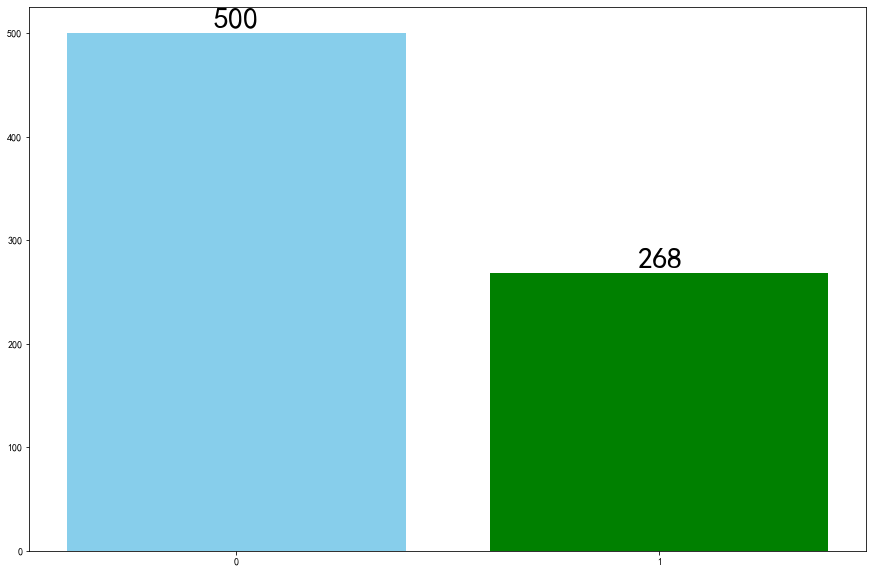

In [4]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()

# 处理数据
## 异常值处理

In [5]:
diabetes.describe()    # 查看数据均值、标准差、最大、最小值、分位数

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


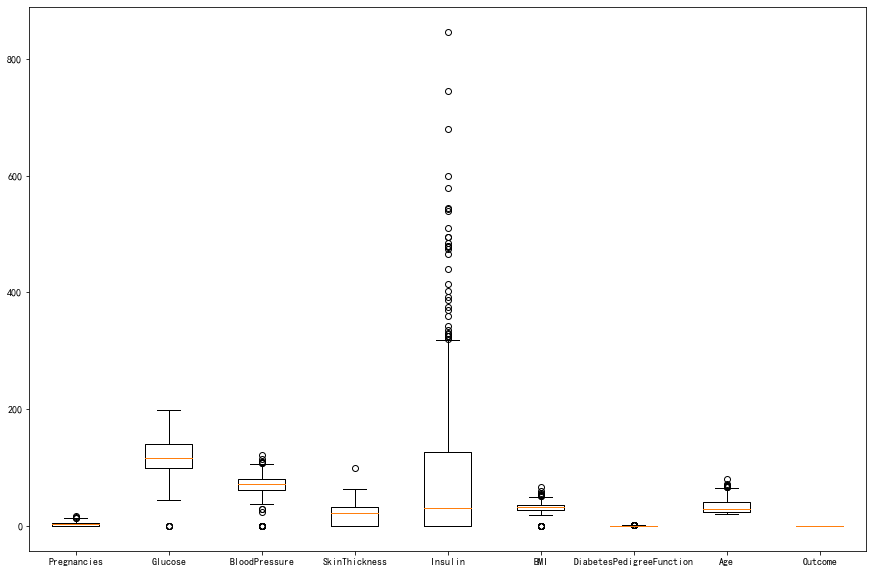

In [6]:
'''通过箱线图观察'''
plt.figure(figsize = (15, 10))
plt.boxplot(diabetes, labels = diabetes.columns)
plt.show()

3$\sigma$原则适用于服从正态分布的数据

箱线图异常值定义为小于$Q_1 - 1.5IQR$或大于$Q_3 + 1.5IQR$  $IQR = Q_3 - Q_1$

而考虑数据信息的丢失，只删除一些明显异常的值：Insulin = 846、skinthickness = 99、 BMI = 67

而怀孕次数、血压、年龄的取值是在合理范围之内，不做异常值处理。

In [7]:
'''处理异常值'''
diabetes = diabetes.loc[~diabetes['Insulin'].isin([846])]
diabetes = diabetes.loc[~diabetes['SkinThickness'].isin([99])]
diabetes = diabetes.loc[~diabetes['BMI'].isin([67.1])]
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# 缺失值处理

2小时血清胰岛素含量、葡萄糖含量、血压、皮脂厚度为0十分反常，可以认为是存在缺失值的。

以同类平均数进行填充

In [8]:
diabetes_0 = diabetes.loc[diabetes['Outcome'] == 0]
diabetes_1 = diabetes.loc[diabetes['Outcome'] == 1]
zero_mean = diabetes_0.mean()
one_mean = diabetes_1.mean()

In [11]:
for attribute in ['Insulin', 'Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    for i in diabetes.index:
        if diabetes[attribute][i] == 0:
            if diabetes['Outcome'][i] == 0:
                diabetes[attribute][i] = zero_mean[attribute]
            else:
                diabetes[attribute][i] = one_mean[attribute] 
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,97,33.6,0.627,50,1
1,1,85,66,29,68,26.6,0.351,31,0
2,8,183,64,21,97,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,68,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,21,97,30.1,0.349,47,1


# 确认处理后数据

In [12]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,765.000,765.000,765.000,765.000,765.000,765.000,765.000,765.000,765.000
mean,3.856,121.489,72.216,26.265,117.186,32.394,0.472,33.179,0.346
std,3.371,30.299,12.058,9.425,90.227,6.778,0.332,11.697,0.476
min,0.000,44.000,24.000,7.000,14.000,18.200,0.078,21.000,0.000
25%,1.000,99.000,64.000,19.000,68.000,27.500,0.243,24.000,0.000
50%,3.000,117.000,72.000,23.000,97.000,32.000,0.371,29.000,0.000
75%,6.000,140.000,80.000,32.000,126.000,36.600,0.627,41.000,1.000
max,17.000,199.000,122.000,63.000,744.000,59.400,2.420,81.000,1.000


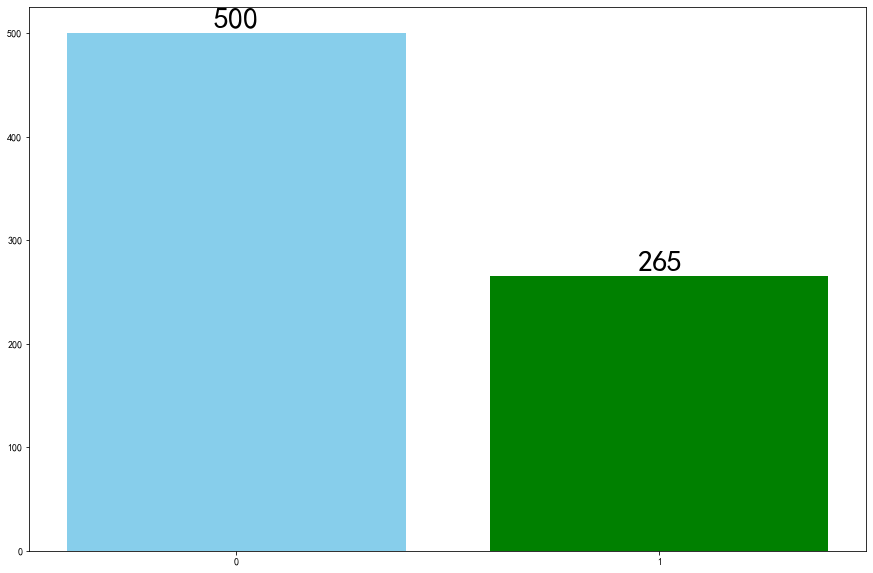

NameError: name 'dia_norm' is not defined

<Figure size 1080x720 with 0 Axes>

In [13]:
plt.figure(figsize = (15, 10))
label_counts = diabetes['Outcome'].value_counts()   # 统计标签频数
plt.bar(label_counts.keys(), label_counts.values, color = ['skyblue', 'g'])
plt.xticks(label_counts.keys())
for a, b in zip(label_counts.keys(), label_counts.values):
    plt.text(a, b, '%.0f'%b, ha = 'center', va = 'bottom', fontsize =30)
plt.show()
plt.figure(figsize = (15, 10))
plt.boxplot(dia_norm, labels = dia_norm.columns)
plt.show()

In [14]:
X = diabetes.iloc[:,:-1]
Y = diabetes.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123457)

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
avg_scores = []
all_scores = []
test_scores = []
parameter_value = list(range(1, 21))
for n_neighbors in parameter_value:
    KNN = KNeighborsClassifier(n_neighbors = n_neighbors)
    scores = cross_val_score(KNN, X_train, y_train, scoring = 'accuracy')
    KNN.fit(X_train, y_train)
    y_pre = KNN.predict(X_test)
    KNN_accuracy = accuracy_score(y_test,y_pre)
    avg_scores.append(np.mean(scores))
    all_scores.append(scores)
    test_scores.append(KNN_accuracy)
end = time.time()
print(f'KNN交叉验证调参运行时间为：{end - start:.4f}')

KNN交叉验证调参运行时间为：1.2377


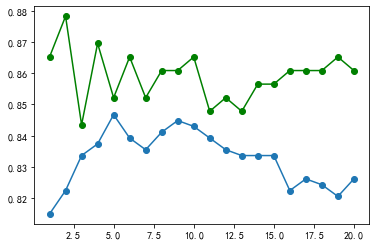

In [31]:
plt.plot(parameter_value, avg_scores, '-o')
plt.plot(parameter_value, test_scores, '-o', color = 'g')
plt.show()

In [57]:
# k = 5
KNN = KNeighborsClassifier(n_neighbors = 7)
KNN.fit(X_train, y_train)
y_pre = KNN.predict(X_test)
KNN_accuracy = accuracy_score(y_test,y_pre)
print(f'测试集准确率为：{KNN_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率为：0.8522
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       153
           1       0.77      0.81      0.78        77

    accuracy                           0.85       230
   macro avg       0.83      0.84      0.84       230
weighted avg       0.85      0.85      0.85       230



准确来说，并不能画出在测试集上的正确率曲线，否则会导致测试集参与模型的训练，发生过拟合。
此处做个参考。k可取10

# 随机森林

In [33]:
from sklearn.ensemble import RandomForestClassifier
start_RT = time.time()
parameter_space = {
    'max_features': [2, 10, 'auto'],
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6]
}
clf = RandomForestClassifier(random_state = 3)
grid_rt = GridSearchCV(clf, parameter_space)
grid_rt.fit(X_train, y_train)
end_RT = time.time()
print(f'随机森林网格搜索调整参数运行时间：{end_RT - start_RT:.4f}')

随机森林网格搜索调整参数运行时间：33.6889


In [20]:
print(grid_rt.best_score_)
print(grid_rt.best_estimator_)

0.8841121495327103
RandomForestClassifier(max_features=2, min_samples_leaf=2, random_state=3)


In [58]:
y_pre = grid_rt.predict(X_test)
RT_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率为：{RT_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率为：0.8957
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       153
           1       0.84      0.86      0.85        77

    accuracy                           0.90       230
   macro avg       0.88      0.89      0.88       230
weighted avg       0.90      0.90      0.90       230



# catboost
梯度提升决策树（GBDT）的改进版，可以更好处理类别数据，并且实现类别之间的组合。

In [49]:
import catboost as cb
start_cb = time.time()
cv_parameter = {'iterations': [100, 200],
               'learning_rate': [0.1, 0.2]
               }
parameter_space = {
    'depth': 3,
    'loss_function': 'Logloss',
    'leaf_estimation_method': 'Newton',
    'random_state': 12
}
cb_model = cb.CatBoostClassifier(parameter_space)
grid_cb = GridSearchCV(cb_model, cv_parameter)
grid_cb.fit(X_train, y_train)
end_cb = time.time()
print(f'CATBOOST网格搜索调部分参数运行时间为：{end_cb - start_cb:.4f}')

0:	learn: 0.6557259	total: 2.34ms	remaining: 232ms
1:	learn: 0.6210538	total: 3.94ms	remaining: 193ms
2:	learn: 0.5903262	total: 5.53ms	remaining: 179ms
3:	learn: 0.5590991	total: 7.3ms	remaining: 175ms
4:	learn: 0.5365467	total: 8.85ms	remaining: 168ms
5:	learn: 0.5149932	total: 10.4ms	remaining: 163ms
6:	learn: 0.4883041	total: 12.4ms	remaining: 165ms
7:	learn: 0.4665902	total: 14.1ms	remaining: 162ms
8:	learn: 0.4460633	total: 15.9ms	remaining: 160ms
9:	learn: 0.4331551	total: 17.2ms	remaining: 155ms
10:	learn: 0.4179631	total: 18.7ms	remaining: 151ms
11:	learn: 0.4050177	total: 20.2ms	remaining: 148ms
12:	learn: 0.3947065	total: 21.7ms	remaining: 145ms
13:	learn: 0.3841923	total: 23.1ms	remaining: 142ms
14:	learn: 0.3742609	total: 25ms	remaining: 142ms
15:	learn: 0.3649219	total: 26.9ms	remaining: 141ms
16:	learn: 0.3553104	total: 28.6ms	remaining: 140ms
17:	learn: 0.3447328	total: 30.1ms	remaining: 137ms
18:	learn: 0.3387281	total: 31.5ms	remaining: 134ms
19:	learn: 0.3313122	tota

0:	learn: 0.6577812	total: 1.75ms	remaining: 174ms
1:	learn: 0.6188471	total: 3.23ms	remaining: 158ms
2:	learn: 0.5926054	total: 4.61ms	remaining: 149ms
3:	learn: 0.5556402	total: 5.93ms	remaining: 142ms
4:	learn: 0.5279974	total: 7.34ms	remaining: 139ms
5:	learn: 0.5069932	total: 9.21ms	remaining: 144ms
6:	learn: 0.4805294	total: 10.6ms	remaining: 141ms
7:	learn: 0.4630073	total: 12.2ms	remaining: 141ms
8:	learn: 0.4473375	total: 13.8ms	remaining: 140ms
9:	learn: 0.4359201	total: 15.4ms	remaining: 139ms
10:	learn: 0.4217897	total: 16.8ms	remaining: 136ms
11:	learn: 0.4093886	total: 18.4ms	remaining: 135ms
12:	learn: 0.3997618	total: 19.9ms	remaining: 133ms
13:	learn: 0.3864135	total: 21.4ms	remaining: 131ms
14:	learn: 0.3742487	total: 22.7ms	remaining: 129ms
15:	learn: 0.3651067	total: 24.1ms	remaining: 127ms
16:	learn: 0.3531668	total: 25.9ms	remaining: 127ms
17:	learn: 0.3423477	total: 27.3ms	remaining: 124ms
18:	learn: 0.3334356	total: 28.7ms	remaining: 122ms
19:	learn: 0.3275302	t

0:	learn: 0.6584161	total: 1.96ms	remaining: 194ms
1:	learn: 0.6204419	total: 3.53ms	remaining: 173ms
2:	learn: 0.5966961	total: 5.08ms	remaining: 164ms
3:	learn: 0.5624670	total: 6.42ms	remaining: 154ms
4:	learn: 0.5369446	total: 8.2ms	remaining: 156ms
5:	learn: 0.5132600	total: 9.55ms	remaining: 150ms
6:	learn: 0.4932646	total: 11.1ms	remaining: 147ms
7:	learn: 0.4750424	total: 12.5ms	remaining: 144ms
8:	learn: 0.4550719	total: 14ms	remaining: 141ms
9:	learn: 0.4401031	total: 15.4ms	remaining: 138ms
10:	learn: 0.4248816	total: 16.8ms	remaining: 136ms
11:	learn: 0.4148677	total: 18.4ms	remaining: 135ms
12:	learn: 0.4025836	total: 19.9ms	remaining: 133ms
13:	learn: 0.3906528	total: 21.2ms	remaining: 130ms
14:	learn: 0.3791929	total: 22.6ms	remaining: 128ms
15:	learn: 0.3695644	total: 24.1ms	remaining: 126ms
16:	learn: 0.3599906	total: 25.4ms	remaining: 124ms
17:	learn: 0.3522069	total: 26.7ms	remaining: 122ms
18:	learn: 0.3453052	total: 28.2ms	remaining: 120ms
19:	learn: 0.3376191	tota

0:	learn: 0.6326404	total: 2.65ms	remaining: 262ms
1:	learn: 0.5815905	total: 4.02ms	remaining: 197ms
2:	learn: 0.5217417	total: 5.75ms	remaining: 186ms
3:	learn: 0.4797315	total: 7.16ms	remaining: 172ms
4:	learn: 0.4414711	total: 8.94ms	remaining: 170ms
5:	learn: 0.4174166	total: 10.7ms	remaining: 167ms
6:	learn: 0.3842337	total: 12.6ms	remaining: 167ms
7:	learn: 0.3614672	total: 14.1ms	remaining: 162ms
8:	learn: 0.3420765	total: 16.2ms	remaining: 164ms
9:	learn: 0.3287924	total: 17.6ms	remaining: 159ms
10:	learn: 0.3159474	total: 19ms	remaining: 154ms
11:	learn: 0.3089113	total: 20.9ms	remaining: 153ms
12:	learn: 0.3013119	total: 22.6ms	remaining: 151ms
13:	learn: 0.2948642	total: 26.3ms	remaining: 162ms
14:	learn: 0.2874899	total: 28.7ms	remaining: 162ms
15:	learn: 0.2839098	total: 30.1ms	remaining: 158ms
16:	learn: 0.2783554	total: 31.6ms	remaining: 155ms
17:	learn: 0.2707671	total: 33.6ms	remaining: 153ms
18:	learn: 0.2675477	total: 35.4ms	remaining: 151ms
19:	learn: 0.2616054	tot

0:	learn: 0.6253173	total: 1.75ms	remaining: 174ms
1:	learn: 0.5517532	total: 3.13ms	remaining: 153ms
2:	learn: 0.5083328	total: 4.58ms	remaining: 148ms
3:	learn: 0.4635821	total: 6ms	remaining: 144ms
4:	learn: 0.4268815	total: 7.43ms	remaining: 141ms
5:	learn: 0.4042881	total: 9.31ms	remaining: 146ms
6:	learn: 0.3800012	total: 10.6ms	remaining: 141ms
7:	learn: 0.3627836	total: 11.9ms	remaining: 137ms
8:	learn: 0.3407354	total: 13.2ms	remaining: 133ms
9:	learn: 0.3301062	total: 14.6ms	remaining: 131ms
10:	learn: 0.3120771	total: 15.9ms	remaining: 129ms
11:	learn: 0.3031871	total: 17.2ms	remaining: 126ms
12:	learn: 0.2957659	total: 18.7ms	remaining: 125ms
13:	learn: 0.2869627	total: 20.3ms	remaining: 125ms
14:	learn: 0.2765989	total: 21.8ms	remaining: 123ms
15:	learn: 0.2691710	total: 23.2ms	remaining: 122ms
16:	learn: 0.2615824	total: 24.7ms	remaining: 121ms
17:	learn: 0.2544101	total: 26ms	remaining: 118ms
18:	learn: 0.2479191	total: 27.5ms	remaining: 117ms
19:	learn: 0.2414900	total:

0:	learn: 0.6054690	total: 1.97ms	remaining: 392ms
1:	learn: 0.5355677	total: 3.79ms	remaining: 375ms
2:	learn: 0.4829406	total: 5.79ms	remaining: 380ms
3:	learn: 0.4406140	total: 7.41ms	remaining: 363ms
4:	learn: 0.3942392	total: 9.12ms	remaining: 356ms
5:	learn: 0.3610492	total: 13.1ms	remaining: 424ms
6:	learn: 0.3285319	total: 15.1ms	remaining: 417ms
7:	learn: 0.3086158	total: 17.2ms	remaining: 412ms
8:	learn: 0.2963999	total: 19.1ms	remaining: 405ms
9:	learn: 0.2865903	total: 20.9ms	remaining: 397ms
10:	learn: 0.2707853	total: 22.6ms	remaining: 389ms
11:	learn: 0.2564794	total: 24.3ms	remaining: 381ms
12:	learn: 0.2436769	total: 26.2ms	remaining: 376ms
13:	learn: 0.2330724	total: 28ms	remaining: 371ms
14:	learn: 0.2274745	total: 29.7ms	remaining: 366ms
15:	learn: 0.2211206	total: 31.5ms	remaining: 363ms
16:	learn: 0.2147366	total: 33.5ms	remaining: 360ms
17:	learn: 0.2107444	total: 35.5ms	remaining: 359ms
18:	learn: 0.2055869	total: 38.3ms	remaining: 365ms
19:	learn: 0.2002167	tot

0:	learn: 0.6137792	total: 2.28ms	remaining: 454ms
1:	learn: 0.5506170	total: 4.86ms	remaining: 481ms
2:	learn: 0.4997804	total: 6.95ms	remaining: 456ms
3:	learn: 0.4525104	total: 9.03ms	remaining: 443ms
4:	learn: 0.4035371	total: 11.1ms	remaining: 433ms
5:	learn: 0.3713011	total: 13.2ms	remaining: 427ms
6:	learn: 0.3411082	total: 15.2ms	remaining: 419ms
7:	learn: 0.3185672	total: 16.9ms	remaining: 406ms
8:	learn: 0.3034532	total: 19ms	remaining: 404ms
9:	learn: 0.2939721	total: 21.3ms	remaining: 404ms
10:	learn: 0.2771322	total: 24.1ms	remaining: 414ms
11:	learn: 0.2651207	total: 25.9ms	remaining: 407ms
12:	learn: 0.2561710	total: 28.7ms	remaining: 413ms
13:	learn: 0.2501034	total: 30.9ms	remaining: 410ms
14:	learn: 0.2438008	total: 32.7ms	remaining: 404ms
15:	learn: 0.2366273	total: 34.8ms	remaining: 400ms
16:	learn: 0.2285807	total: 37.1ms	remaining: 399ms
17:	learn: 0.2236183	total: 38.8ms	remaining: 393ms
18:	learn: 0.2193897	total: 40.5ms	remaining: 386ms
19:	learn: 0.2139573	tot

175:	learn: 0.0243790	total: 320ms	remaining: 43.6ms
176:	learn: 0.0242260	total: 322ms	remaining: 41.8ms
177:	learn: 0.0238929	total: 324ms	remaining: 40.1ms
178:	learn: 0.0237382	total: 327ms	remaining: 38.3ms
179:	learn: 0.0236081	total: 329ms	remaining: 36.5ms
180:	learn: 0.0230521	total: 331ms	remaining: 34.7ms
181:	learn: 0.0226640	total: 334ms	remaining: 33ms
182:	learn: 0.0224755	total: 336ms	remaining: 31.3ms
183:	learn: 0.0222234	total: 340ms	remaining: 29.5ms
184:	learn: 0.0221683	total: 348ms	remaining: 28.2ms
185:	learn: 0.0221317	total: 349ms	remaining: 26.3ms
186:	learn: 0.0218687	total: 351ms	remaining: 24.4ms
187:	learn: 0.0215748	total: 353ms	remaining: 22.5ms
188:	learn: 0.0214742	total: 355ms	remaining: 20.6ms
189:	learn: 0.0213357	total: 357ms	remaining: 18.8ms
190:	learn: 0.0210905	total: 359ms	remaining: 16.9ms
191:	learn: 0.0210767	total: 360ms	remaining: 15ms
192:	learn: 0.0209305	total: 362ms	remaining: 13.1ms
193:	learn: 0.0208853	total: 364ms	remaining: 11.3

155:	learn: 0.0292741	total: 316ms	remaining: 89.2ms
156:	learn: 0.0291574	total: 318ms	remaining: 87ms
157:	learn: 0.0289418	total: 319ms	remaining: 84.9ms
158:	learn: 0.0288837	total: 321ms	remaining: 82.9ms
159:	learn: 0.0286752	total: 324ms	remaining: 80.9ms
160:	learn: 0.0280817	total: 325ms	remaining: 78.8ms
161:	learn: 0.0278552	total: 327ms	remaining: 76.7ms
162:	learn: 0.0277729	total: 329ms	remaining: 74.6ms
163:	learn: 0.0275526	total: 330ms	remaining: 72.5ms
164:	learn: 0.0269953	total: 333ms	remaining: 70.5ms
165:	learn: 0.0265778	total: 335ms	remaining: 68.6ms
166:	learn: 0.0260014	total: 337ms	remaining: 66.6ms
167:	learn: 0.0255525	total: 339ms	remaining: 64.5ms
168:	learn: 0.0252184	total: 341ms	remaining: 62.5ms
169:	learn: 0.0251077	total: 342ms	remaining: 60.4ms
170:	learn: 0.0247365	total: 344ms	remaining: 58.3ms
171:	learn: 0.0243543	total: 346ms	remaining: 56.3ms
172:	learn: 0.0241633	total: 348ms	remaining: 54.3ms
173:	learn: 0.0240106	total: 349ms	remaining: 52

163:	learn: 0.0264467	total: 317ms	remaining: 69.6ms
164:	learn: 0.0262885	total: 319ms	remaining: 67.7ms
165:	learn: 0.0261158	total: 321ms	remaining: 65.7ms
166:	learn: 0.0260397	total: 323ms	remaining: 63.7ms
167:	learn: 0.0260001	total: 324ms	remaining: 61.7ms
168:	learn: 0.0258082	total: 326ms	remaining: 59.7ms
169:	learn: 0.0254846	total: 328ms	remaining: 57.9ms
170:	learn: 0.0250152	total: 330ms	remaining: 55.9ms
171:	learn: 0.0246932	total: 332ms	remaining: 54ms
172:	learn: 0.0241754	total: 334ms	remaining: 52.1ms
173:	learn: 0.0238716	total: 336ms	remaining: 50.1ms
174:	learn: 0.0236335	total: 338ms	remaining: 48.2ms
175:	learn: 0.0233816	total: 340ms	remaining: 46.4ms
176:	learn: 0.0232477	total: 342ms	remaining: 44.4ms
177:	learn: 0.0230558	total: 344ms	remaining: 42.5ms
178:	learn: 0.0228075	total: 345ms	remaining: 40.5ms
179:	learn: 0.0226139	total: 348ms	remaining: 38.6ms
180:	learn: 0.0223672	total: 351ms	remaining: 36.8ms
181:	learn: 0.0219730	total: 353ms	remaining: 34

153:	learn: 0.0235033	total: 313ms	remaining: 93.6ms
154:	learn: 0.0232566	total: 315ms	remaining: 91.5ms
155:	learn: 0.0229429	total: 317ms	remaining: 89.4ms
156:	learn: 0.0229269	total: 319ms	remaining: 87.2ms
157:	learn: 0.0229118	total: 321ms	remaining: 85.2ms
158:	learn: 0.0228094	total: 322ms	remaining: 83.1ms
159:	learn: 0.0223353	total: 324ms	remaining: 80.9ms
160:	learn: 0.0222686	total: 325ms	remaining: 78.8ms
161:	learn: 0.0222557	total: 327ms	remaining: 76.7ms
162:	learn: 0.0221371	total: 329ms	remaining: 74.6ms
163:	learn: 0.0221161	total: 331ms	remaining: 72.6ms
164:	learn: 0.0219785	total: 333ms	remaining: 70.5ms
165:	learn: 0.0217373	total: 334ms	remaining: 68.5ms
166:	learn: 0.0215189	total: 336ms	remaining: 66.4ms
167:	learn: 0.0213456	total: 338ms	remaining: 64.5ms
168:	learn: 0.0210627	total: 341ms	remaining: 62.5ms
169:	learn: 0.0208784	total: 343ms	remaining: 60.5ms
170:	learn: 0.0207735	total: 345ms	remaining: 58.4ms
171:	learn: 0.0206594	total: 346ms	remaining: 

159:	learn: 0.0100648	total: 313ms	remaining: 78.3ms
160:	learn: 0.0099495	total: 315ms	remaining: 76.3ms
161:	learn: 0.0099323	total: 317ms	remaining: 74.3ms
162:	learn: 0.0099323	total: 318ms	remaining: 72.3ms
163:	learn: 0.0098084	total: 320ms	remaining: 70.3ms
164:	learn: 0.0097907	total: 322ms	remaining: 68.3ms
165:	learn: 0.0097464	total: 323ms	remaining: 66.2ms
166:	learn: 0.0097239	total: 325ms	remaining: 64.3ms
167:	learn: 0.0096556	total: 327ms	remaining: 62.4ms
168:	learn: 0.0096368	total: 330ms	remaining: 60.5ms
169:	learn: 0.0095226	total: 332ms	remaining: 58.6ms
170:	learn: 0.0095003	total: 334ms	remaining: 56.7ms
171:	learn: 0.0093938	total: 336ms	remaining: 54.8ms
172:	learn: 0.0093922	total: 338ms	remaining: 52.8ms
173:	learn: 0.0093655	total: 340ms	remaining: 50.8ms
174:	learn: 0.0093654	total: 342ms	remaining: 48.8ms
175:	learn: 0.0093616	total: 344ms	remaining: 46.9ms
176:	learn: 0.0092713	total: 346ms	remaining: 45ms
177:	learn: 0.0092258	total: 348ms	remaining: 43

160:	learn: 0.0101387	total: 317ms	remaining: 76.7ms
161:	learn: 0.0100637	total: 319ms	remaining: 74.8ms
162:	learn: 0.0100086	total: 321ms	remaining: 72.8ms
163:	learn: 0.0098774	total: 323ms	remaining: 70.8ms
164:	learn: 0.0098365	total: 325ms	remaining: 68.9ms
165:	learn: 0.0097288	total: 327ms	remaining: 66.9ms
166:	learn: 0.0096516	total: 328ms	remaining: 64.9ms
167:	learn: 0.0096400	total: 330ms	remaining: 62.8ms
168:	learn: 0.0096080	total: 331ms	remaining: 60.8ms
169:	learn: 0.0095306	total: 334ms	remaining: 58.9ms
170:	learn: 0.0095304	total: 335ms	remaining: 56.9ms
171:	learn: 0.0093885	total: 337ms	remaining: 54.9ms
172:	learn: 0.0093045	total: 339ms	remaining: 52.9ms
173:	learn: 0.0092204	total: 341ms	remaining: 50.9ms
174:	learn: 0.0090007	total: 343ms	remaining: 49ms
175:	learn: 0.0088564	total: 345ms	remaining: 47ms
176:	learn: 0.0087555	total: 348ms	remaining: 45.2ms
177:	learn: 0.0087459	total: 350ms	remaining: 43.2ms
178:	learn: 0.0087411	total: 351ms	remaining: 41.2

158:	learn: 0.0094591	total: 310ms	remaining: 80ms
159:	learn: 0.0093384	total: 313ms	remaining: 78.1ms
160:	learn: 0.0093186	total: 315ms	remaining: 76.2ms
161:	learn: 0.0093164	total: 316ms	remaining: 74.1ms
162:	learn: 0.0093017	total: 317ms	remaining: 72.1ms
163:	learn: 0.0092808	total: 319ms	remaining: 70ms
164:	learn: 0.0092558	total: 321ms	remaining: 68ms
165:	learn: 0.0091583	total: 323ms	remaining: 66.1ms
166:	learn: 0.0090984	total: 324ms	remaining: 64.1ms
167:	learn: 0.0090611	total: 326ms	remaining: 62.1ms
168:	learn: 0.0090147	total: 328ms	remaining: 60.2ms
169:	learn: 0.0090147	total: 330ms	remaining: 58.2ms
170:	learn: 0.0089513	total: 332ms	remaining: 56.3ms
171:	learn: 0.0089141	total: 334ms	remaining: 54.4ms
172:	learn: 0.0088133	total: 336ms	remaining: 52.5ms
173:	learn: 0.0087334	total: 338ms	remaining: 50.5ms
174:	learn: 0.0086986	total: 340ms	remaining: 48.5ms
175:	learn: 0.0086631	total: 342ms	remaining: 46.6ms
176:	learn: 0.0085540	total: 343ms	remaining: 44.6ms

153:	learn: 0.0100263	total: 309ms	remaining: 92.2ms
154:	learn: 0.0099763	total: 310ms	remaining: 90.1ms
155:	learn: 0.0099707	total: 312ms	remaining: 88.1ms
156:	learn: 0.0099495	total: 315ms	remaining: 86.2ms
157:	learn: 0.0099495	total: 316ms	remaining: 84.1ms
158:	learn: 0.0099159	total: 318ms	remaining: 82.1ms
159:	learn: 0.0098580	total: 320ms	remaining: 80ms
160:	learn: 0.0098580	total: 321ms	remaining: 77.8ms
161:	learn: 0.0098345	total: 323ms	remaining: 75.8ms
162:	learn: 0.0098076	total: 325ms	remaining: 73.7ms
163:	learn: 0.0098025	total: 326ms	remaining: 71.7ms
164:	learn: 0.0097576	total: 328ms	remaining: 69.6ms
165:	learn: 0.0097281	total: 330ms	remaining: 67.5ms
166:	learn: 0.0096871	total: 332ms	remaining: 65.5ms
167:	learn: 0.0096346	total: 334ms	remaining: 63.6ms
168:	learn: 0.0095140	total: 336ms	remaining: 61.7ms
169:	learn: 0.0093214	total: 339ms	remaining: 59.7ms
170:	learn: 0.0092173	total: 340ms	remaining: 57.7ms
171:	learn: 0.0090627	total: 342ms	remaining: 55

155:	learn: 0.0076247	total: 310ms	remaining: 87.4ms
156:	learn: 0.0076085	total: 311ms	remaining: 85.3ms
157:	learn: 0.0075502	total: 313ms	remaining: 83.3ms
158:	learn: 0.0075267	total: 315ms	remaining: 81.2ms
159:	learn: 0.0074709	total: 317ms	remaining: 79.2ms
160:	learn: 0.0074482	total: 318ms	remaining: 77.1ms
161:	learn: 0.0073393	total: 320ms	remaining: 75.1ms
162:	learn: 0.0072467	total: 322ms	remaining: 73.1ms
163:	learn: 0.0072152	total: 324ms	remaining: 71.1ms
164:	learn: 0.0071122	total: 326ms	remaining: 69.2ms
165:	learn: 0.0070881	total: 328ms	remaining: 67.2ms
166:	learn: 0.0070491	total: 330ms	remaining: 65.3ms
167:	learn: 0.0070177	total: 332ms	remaining: 63.2ms
168:	learn: 0.0068975	total: 334ms	remaining: 61.2ms
169:	learn: 0.0067892	total: 335ms	remaining: 59.2ms
170:	learn: 0.0067080	total: 337ms	remaining: 57.1ms
171:	learn: 0.0066865	total: 339ms	remaining: 55.1ms
172:	learn: 0.0066751	total: 340ms	remaining: 53.1ms
173:	learn: 0.0066271	total: 342ms	remaining: 

In [52]:
print(grid_cb.best_score_)
print(grid_cb.best_estimator_)

0.8785046728971964


In [59]:
y_pre = grid_cb.predict(X_test)
cb_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率;{cb_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率;0.8913
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       153
           1       0.82      0.86      0.84        77

    accuracy                           0.89       230
   macro avg       0.88      0.88      0.88       230
weighted avg       0.89      0.89      0.89       230



# SVM

In [43]:
from sklearn.svm import SVC
start_svr = time.time()
parameters = {'kernel':('linear', 'rbf'), 'C': [1, 10]}
svr = SVC()
grid_svc = GridSearchCV(svr, parameters)
grid_svc.fit(X_train, y_train)
end_svr = time.time()
print(f'SVM网格搜索调参的运行时间为：{end_svr - start_svr : .4f}')

SVM网格搜索调参的运行时间为： 78.5550


In [44]:
print(grid_svc.best_score_)
print(grid_svc.best_estimator_)

0.8317757009345795
SVC(C=10)


In [60]:
y_pre = grid_svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率：{svc_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率：0.8565
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       153
           1       0.79      0.78      0.78        77

    accuracy                           0.86       230
   macro avg       0.84      0.84      0.84       230
weighted avg       0.86      0.86      0.86       230



# voting

In [46]:
from mlxtend.classifier import EnsembleVoteClassifier

start_vote = time.time()
KNN = KNeighborsClassifier(n_neighbors = 7)
clf = RandomForestClassifier(criterion='entropy', max_features=2, min_samples_leaf=6,
                       n_estimators=200, random_state=3)
svr = SVC(C=10, kernel='linear', probability = True)
eclf = EnsembleVoteClassifier(clfs = [KNN, clf, svr], weights = [1, 2, 2], voting = 'soft')
eclf.fit(X_train, y_train)
end_vote = time.time()
print(f'voting法运行时间为： {end_vote - start_vote : .4f}')

voting法运行时间为：  69.0634


In [61]:
y_pre = eclf.predict(X_test)
es_accuracy = accuracy_score(y_test, y_pre)
print(f'测试集准确率:{es_accuracy:.4f}')
print(classification_report(y_test, y_pre))

测试集准确率:0.8739
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       153
           1       0.82      0.79      0.81        77

    accuracy                           0.87       230
   macro avg       0.86      0.85      0.86       230
weighted avg       0.87      0.87      0.87       230

